# Phase 1.5: Complete ML Metrics & MLflow Tracking

This comprehensive notebook demonstrates:
1. **Data Exploration** - Visualize and understand the wine dataset
2. **Model Training** - Train RandomForest with different hyperparameters
3. **Complete Metrics** - Learn ALL important ML evaluation metrics
4. **MLflow Tracking** - Log everything for comparison

## 🎯 Learning Goals
- Understand how machine learning models learn from data
- Master ALL important evaluation metrics
- See the difference between training and test data
- Use MLflow to track comprehensive experiments

## 📦 Step 1: Import Libraries

In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.datasets import load_wine
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Import ALL important metrics
from sklearn.metrics import (
    # Basic Classification Metrics
    accuracy_score,           # Overall correctness: (Correct Predictions) / (Total Predictions)
    precision_score,          # "Quality" - Of all predicted positives, how many were actually positive? (Use when False Positives are expensive)
    recall_score,             # "Quantity" - Of all actual positives, how many did we find? (Use when False Negatives are expensive)
    f1_score,                 # Balance between Precision and Recall (Harmonic mean) - Best for imbalanced datasets
    
    # Advanced Classification Metrics
    roc_auc_score,            # Area Under Curve - Probability that model ranks a random positive higher than a random negative (0.5=random, 1.0=perfect)
    balanced_accuracy_score,  # Average recall of each class - Crucial when one class is much larger than the other
    matthews_corrcoef,        # MCC - Correlation between predicted and observed (-1 to +1). Considered mostly robust metric for binary classification.
    cohen_kappa_score,        # "Inter-rater reliability" - Agreement between model and truth, accounting for agreement by chance
    log_loss,                 # "Confidence penalty" - Punishes wrong predictions more if the model was confident about them
    
    # Confusion Matrix & Reports
    confusion_matrix,         # The raw grid: True Positives, True Negatives, False Positives, False Negatives
    classification_report,    # A ready-made text report showing Precision, Recall, and F1 for every class
    
    # Visualization Helpers
    ConfusionMatrixDisplay,   # Helper to draw the confusion matrix heatmap
    RocCurveDisplay,          # Helper to plot the ROC curve (True Positive Rate vs False Positive Rate)
    PrecisionRecallDisplay,   # Helper to plot Precision vs Recall Trade-off curve
)

import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ All libraries imported successfully!")
print("📊 Ready to explore comprehensive ML metrics!")

✅ All libraries imported successfully!
📊 Ready to explore comprehensive ML metrics!


## 🔗 Step 2: Connect to MLflow

In [ ]:
TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment("wine-classification-experiment")

print(f"✅ Connected to MLflow at: {TRACKING_URI}")
print(f"📊 Experiment: wine-classification-experiment")

## 📊 Step 3: Load and Explore the wine Dataset

In [3]:
# Load the dataset
wine = load_wine()
X = wine.data
y = wine.target
# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=wine.feature_names)
df['wine_class'] = pd.Categorical.from_codes(y, wine.target_names)
df['class_code'] = y
print(f"📊 Dataset Shape: {df.shape}")
print(f"🍷 Features: {list(wine.feature_names)}")
print(f"🏷️  Classes: {list(wine.target_names)}")
print(f"\n📋 First 5 rows:")
df.head()

📊 Dataset Shape: (178, 15)
🍷 Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
🏷️  Classes: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]

📋 First 5 rows:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class,class_code
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0,0


In [ ]:
# Pairplot to see relationships (using subset of features for wine dataset - 13 features is too many)
# Select key features for visualization
key_features = ['alcohol', 'malic_acid', 'flavanoids', 'color_intensity', 'wine_class']
df_subset = df[key_features]

sns.pairplot(df_subset, hue='wine_class', palette='Set2', diag_kind='kde', height=2.5)
plt.suptitle('Wine Dataset - Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Notice how different wine classes cluster together!")

## ✂️ Step 4: Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data split complete!")
print(f"📊 Training: {len(X_train)} samples | Test: {len(X_test)} samples")

✅ Data split complete!
📊 Training: 120 samples | Test: 30 samples


## 🤖 Step 5: Train Model & Calculate ALL Metrics

Let's train a model and calculate EVERY important metric to understand what each one means!

In [ ]:
# Train a model
params = {"n_estimators": 50, "max_depth": 5, "min_samples_split": 2, "random_state": 42}
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("✅ Model trained!")
print(f"📊 Made predictions on {len(y_test)} test samples")

✅ Model trained!
📊 Made predictions on 30 test samples


## 📈 Step 6: Calculate & Understand ALL Metrics

### 🎯 Basic Metrics

In [ ]:
print("=" * 80)
print("BASIC CLASSIFICATION METRICS")
print("=" * 80)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1️⃣ ACCURACY: {accuracy:.4f}")
print(f"   📖 What it means: {accuracy*100:.1f}% of predictions were correct")
print(f"   💡 Formula: (Correct Predictions) / (Total Predictions)")
print(f"   ⚠️  Limitation: Can be misleading with imbalanced classes")

# 2. Precision (for multi-class, we'll use weighted average)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\n2️⃣ PRECISION: {precision:.4f}")
print(f"   📖 What it means: When model predicts a class, it's correct {precision*100:.1f}% of the time")
print(f"   💡 Formula: (True Positives) / (True Positives + False Positives)")
print(f"   🎯 Use when: False positives are costly (e.g., spam detection)")

# 3. Recall (Sensitivity)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"\n3️⃣ RECALL (Sensitivity): {recall:.4f}")
print(f"   📖 What it means: Model finds {recall*100:.1f}% of actual instances")
print(f"   💡 Formula: (True Positives) / (True Positives + False Negatives)")
print(f"   🎯 Use when: False negatives are costly (e.g., disease detection)")

# 4. F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n4️⃣ F1 SCORE: {f1:.4f}")
print(f"   📖 What it means: Harmonic mean of precision and recall")
print(f"   💡 Formula: 2 * (Precision * Recall) / (Precision + Recall)")
print(f"   🎯 Use when: You need balance between precision and recall")

BASIC CLASSIFICATION METRICS

1️⃣ ACCURACY: 0.9000
   📖 What it means: 90.0% of predictions were correct
   💡 Formula: (Correct Predictions) / (Total Predictions)
   ⚠️  Limitation: Can be misleading with imbalanced classes

2️⃣ PRECISION: 0.9024
   📖 What it means: When model predicts a class, it's correct 90.2% of the time
   💡 Formula: (True Positives) / (True Positives + False Positives)
   🎯 Use when: False positives are costly (e.g., spam detection)

3️⃣ RECALL (Sensitivity): 0.9000
   📖 What it means: Model finds 90.0% of actual instances
   💡 Formula: (True Positives) / (True Positives + False Negatives)
   🎯 Use when: False negatives are costly (e.g., disease detection)

4️⃣ F1 SCORE: 0.8997
   📖 What it means: Harmonic mean of precision and recall
   💡 Formula: 2 * (Precision * Recall) / (Precision + Recall)
   🎯 Use when: You need balance between precision and recall


### 🔬 Advanced Metrics

In [ ]:
print("\n" + "=" * 80)
print("ADVANCED CLASSIFICATION METRICS")
print("=" * 80)

# 5. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\n5️⃣ ROC AUC SCORE: {roc_auc:.4f}")
print(f"   📖 What it means: Area under ROC curve - model's ability to separate classes")
print(f"   💡 Range: 0.5 (random) to 1.0 (perfect)")
print(f"   🎯 Use when: Evaluating probability predictions")

# 6. Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\n6️⃣ BALANCED ACCURACY: {balanced_acc:.4f}")
print(f"   📖 What it means: Accuracy adjusted for class imbalance")
print(f"   💡 Formula: Average of recall for each class")
print(f"   🎯 Use when: Classes are imbalanced")

# 7. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\n7️⃣ MATTHEWS CORRELATION COEFFICIENT: {mcc:.4f}")
print(f"   📖 What it means: Correlation between predictions and actual values")
print(f"   💡 Range: -1 (worst) to +1 (perfect), 0 (random)")
print(f"   🎯 Use when: Need a single metric that works well with imbalanced data")

# 8. Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\n8️⃣ COHEN'S KAPPA: {kappa:.4f}")
print(f"   📖 What it means: Agreement between predictions and actual, accounting for chance")
print(f"   💡 Range: -1 to +1, where 1 is perfect agreement")
print(f"   🎯 Use when: Want to account for random chance in predictions")

# 9. Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"\n9️⃣ LOG LOSS: {logloss:.4f}")
print(f"   📖 What it means: Penalizes confident wrong predictions heavily")
print(f"   💡 Range: 0 (perfect) to infinity (worse)")
print(f"   🎯 Use when: Probability calibration matters")


ADVANCED CLASSIFICATION METRICS

5️⃣ ROC AUC SCORE: 0.9867
   📖 What it means: Area under ROC curve - model's ability to separate classes
   💡 Range: 0.5 (random) to 1.0 (perfect)
   🎯 Use when: Evaluating probability predictions

6️⃣ BALANCED ACCURACY: 0.9000
   📖 What it means: Accuracy adjusted for class imbalance
   💡 Formula: Average of recall for each class
   🎯 Use when: Classes are imbalanced

7️⃣ MATTHEWS CORRELATION COEFFICIENT: 0.8514
   📖 What it means: Correlation between predictions and actual values
   💡 Range: -1 (worst) to +1 (perfect), 0 (random)
   🎯 Use when: Need a single metric that works well with imbalanced data

8️⃣ COHEN'S KAPPA: 0.8500
   📖 What it means: Agreement between predictions and actual, accounting for chance
   💡 Range: -1 to +1, where 1 is perfect agreement
   🎯 Use when: Want to account for random chance in predictions

9️⃣ LOG LOSS: 0.2019
   📖 What it means: Penalizes confident wrong predictions heavily
   💡 Range: 0 (perfect) to infinity (wors

### 📊 Confusion Matrix - Visual Understanding


CONFUSION MATRIX


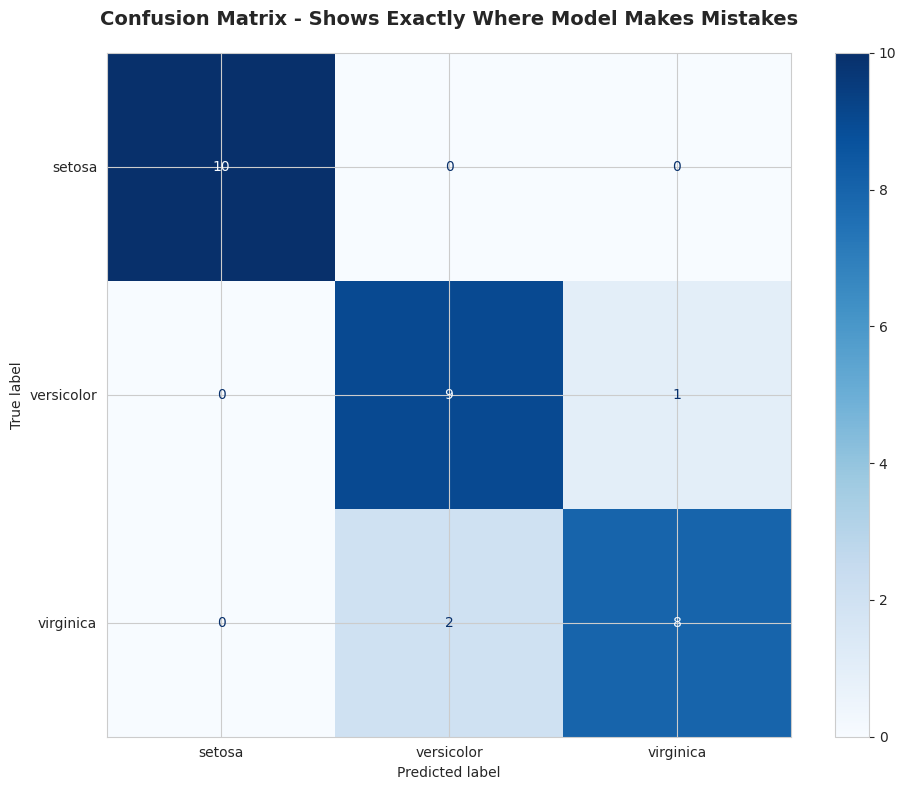


💡 How to read the Confusion Matrix:
   - Rows = Actual class
   - Columns = Predicted class
   - Diagonal = Correct predictions
   - Off-diagonal = Mistakes

📊 Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]


In [ ]:
print("\n" + "=" * 80)
print("CONFUSION MATRIX")
print("=" * 80)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wine.target_names)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Shows Exactly Where Model Makes Mistakes', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 How to read the Confusion Matrix:")
print("   - Rows = Actual class")
print("   - Columns = Predicted class")
print("   - Diagonal = Correct predictions")
print("   - Off-diagonal = Mistakes")
print(f"\n📊 Confusion Matrix:\n{cm}")

### 📋 Classification Report - Everything in One Place

In [ ]:
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - Complete Per-Class Metrics")
print("=" * 80)

report = classification_report(y_test, y_pred, target_names=wine.target_names)
print(f"\n{report}")

print("\n💡 How to read the Classification Report:")
print("   - precision: Of all predicted X, how many were actually X?")
print("   - recall: Of all actual X, how many did we find?")
print("   - f1-score: Harmonic mean of precision and recall")
print("   - support: Number of actual instances of each class")


CLASSIFICATION REPORT - Complete Per-Class Metrics

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


💡 How to read the Classification Report:
   - precision: Of all predicted X, how many were actually X?
   - recall: Of all actual X, how many did we find?
   - f1-score: Harmonic mean of precision and recall
   - support: Number of actual instances of each class


### 🎨 ROC Curves - Visual Performance

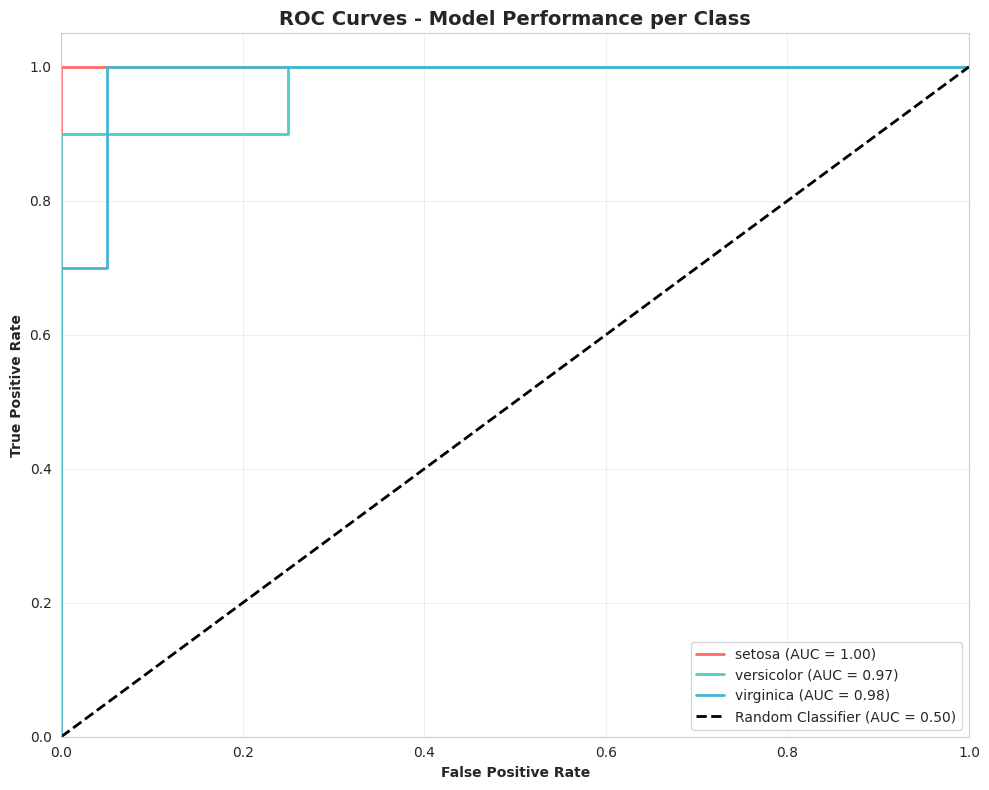

💡 How to read ROC Curves:
   - Closer to top-left corner = Better performance
   - AUC = 1.0: Perfect classifier
   - AUC = 0.5: Random guessing (diagonal line)
   - AUC < 0.5: Worse than random (doing something wrong!)


In [ ]:
# Plot ROC curves for each class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc_class = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f'{wine.target_names[i]} (AUC = {roc_auc_class:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('ROC Curves - Model Performance per Class', fontsize=14, fontweight='bold')
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 How to read ROC Curves:")
print("   - Closer to top-left corner = Better performance")
print("   - AUC = 1.0: Perfect classifier")
print("   - AUC = 0.5: Random guessing (diagonal line)")
print("   - AUC < 0.5: Worse than random (doing something wrong!)")

## 🔄 Step 7: Cross-Validation - More Robust Evaluation

CROSS-VALIDATION SCORES

📊 5-Fold Cross-Validation Accuracy Scores:
   Fold 1: 0.9667
   Fold 2: 0.9667
   Fold 3: 0.9333
   Fold 4: 0.9667
   Fold 5: 1.0000

📈 Summary:
   Mean Accuracy: 0.9667
   Std Deviation: 0.0211

💡 What is Cross-Validation?
   - Splits data into K folds (here K=5)
   - Trains on K-1 folds, tests on remaining fold
   - Repeats K times, each fold used as test once
   - More reliable than single train/test split
   - Helps detect overfitting


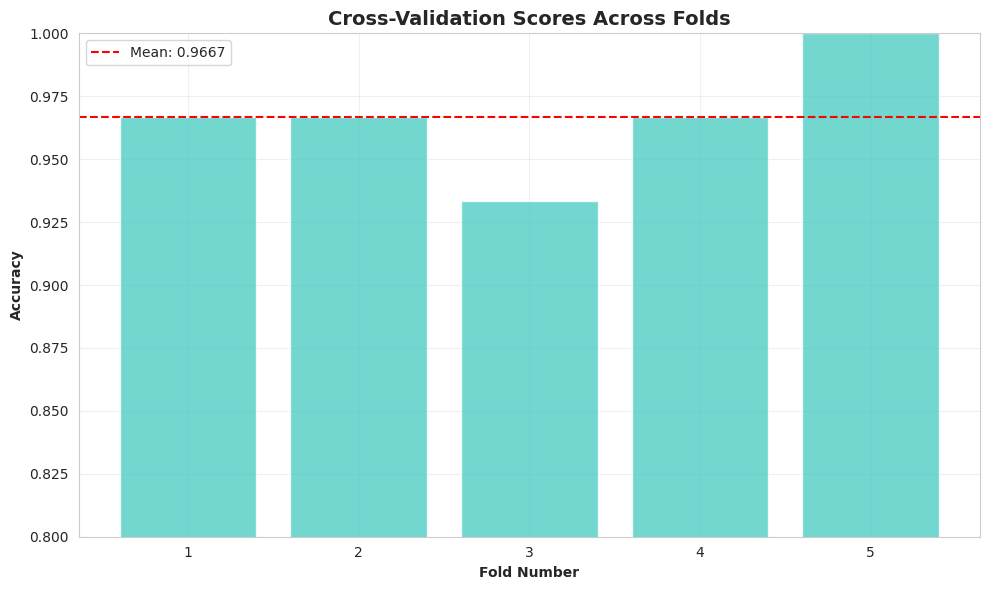

In [ ]:
print("=" * 80)
print("CROSS-VALIDATION SCORES")
print("=" * 80)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"\n📊 5-Fold Cross-Validation Accuracy Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"\n📈 Summary:")
print(f"   Mean Accuracy: {cv_scores.mean():.4f}")
print(f"   Std Deviation: {cv_scores.std():.4f}")

print(f"\n💡 What is Cross-Validation?")
print(f"   - Splits data into K folds (here K=5)")
print(f"   - Trains on K-1 folds, tests on remaining fold")
print(f"   - Repeats K times, each fold used as test once")
print(f"   - More reliable than single train/test split")
print(f"   - Helps detect overfitting")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='#4ECDC4', alpha=0.8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Cross-Validation Scores Across Folds', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim([0.8, 1.0])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 📊 Step 8: Log Everything to MLflow

In [ ]:
with mlflow.start_run(run_name="wine-classification-run"):
    
    # Log dataset (MLflow 2.0+ feature - Formal dataset tracking)
    from mlflow.data.pandas_dataset import from_pandas
    
    # Create dataset object from training data
    train_df = pd.DataFrame(X_train, columns=wine.feature_names)
    train_df["target"] = y_train
    
    dataset = from_pandas(
        train_df, 
        source="sklearn.datasets.load_wine",
        name="wine_training_data",
        targets="target"
    )
    mlflow.log_input(dataset, context="training")
    
    print("✅ Dataset logged to MLflow!")

    # Log parameters
    mlflow.log_params(params)
    
    # Log ALL metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("balanced_accuracy", balanced_acc)
    mlflow.log_metric("matthews_corrcoef", mcc)
    mlflow.log_metric("cohen_kappa", kappa)
    mlflow.log_metric("log_loss", logloss)
    mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
    mlflow.log_metric("cv_std_accuracy", cv_scores.std())
    
    # Log tags (custom tags appear in Tags column)
    mlflow.set_tag("model_type", "RandomForest")
    mlflow.set_tag("dataset", "Wine")
    mlflow.set_tag("metrics_logged", "complete")
    
    print("✅ All metrics logged to MLflow!")
    print(f"\n🌐 View in MLflow UI: {TRACKING_URI}")
    
    # Log and register the model (INSIDE the run context)
    model_name = "wine-random-forest"
    
    mlflow.sklearn.log_model(
        model, 
        "model",
        registered_model_name=model_name
    )
    
    # Set descriptions and get version info
    import time
    time.sleep(1)
    
    from mlflow.tracking import MlflowClient
    client = MlflowClient()
    
    latest_versions = client.get_latest_versions(model_name, stages=["None"])
    if latest_versions:
        latest_version = latest_versions[0]
        version_num = latest_version.version
        
        # Update Model Registry descriptions
        client.update_model_version(
            name=model_name,
            version=version_num,
            description="RandomForest classifier for Wine dataset with complete metrics"
        )
        
        client.update_registered_model(
            name=model_name,
            description="Wine cultivar classification model using RandomForest"
        )
        
        # Set RUN Description (appears in "Description" column in Experiments view)
        run_description = f"Wine RF (v{version_num}) - Acc: {accuracy:.2%}, F1: {f1:.4f}"
        mlflow.set_tag("mlflow.note.content", run_description)
        
        # Set Version info (appears in "Version" column in Experiments view)
        mlflow.set_tag("mlflow.source.git.commit", f"v{version_num}")
        
        print(f"✅ Model registered: {model_name} v{version_num}")
        print(f"✅ Run Description set: {run_description}")
        print(f"✅ Version column set: v{version_num}")

## 🎯 Step 9: Metrics Summary & When to Use Each

In [ ]:
# Create a summary table
metrics_summary = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'ROC AUC',
        'Balanced Accuracy',
        'Matthews Corr Coef',
        'Cohen Kappa',
        'Log Loss'
    ],
    'Value': [
        f"{accuracy:.4f}",
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{balanced_acc:.4f}",
        f"{mcc:.4f}",
        f"{kappa:.4f}",
        f"{logloss:.4f}"
    ],
    'Best For': [
        'Balanced datasets, overall performance',
        'When false positives are costly',
        'When false negatives are costly',
        'Balance between precision & recall',
        'Probability predictions, ranking',
        'Imbalanced datasets',
        'Imbalanced data, single metric',
        'Inter-rater agreement',
        'Probability calibration'
    ]
})

print("\n" + "=" * 100)
print("METRICS SUMMARY - WHEN TO USE EACH METRIC")
print("=" * 100)
print(metrics_summary.to_string(index=False))

print("\n" + "=" * 100)
print("KEY TAKEAWAYS")
print("=" * 100)
print("\n1️⃣ NO SINGLE METRIC IS PERFECT")
print("   - Always look at multiple metrics")
print("   - Choose metrics based on your problem")

print("\n2️⃣ UNDERSTAND THE TRADEOFFS")
print("   - High precision → Low false positives (but might miss some)")
print("   - High recall → Find everything (but more false alarms)")
print("   - F1 score → Balance between both")

print("\n3️⃣ CONTEXT MATTERS")
print("   - Medical diagnosis → Prioritize RECALL (don't miss diseases)")
print("   - Spam detection → Prioritize PRECISION (don't block real emails)")
print("   - Fraud detection → Balance with F1 SCORE")

print("\n4️⃣ USE CROSS-VALIDATION")
print("   - More reliable than single train/test split")
print("   - Helps detect overfitting")
print("   - Shows model stability")


METRICS SUMMARY - WHEN TO USE EACH METRIC
            Metric  Value                               Best For
          Accuracy 0.9000 Balanced datasets, overall performance
         Precision 0.9024        When false positives are costly
            Recall 0.9000        When false negatives are costly
          F1 Score 0.8997     Balance between precision & recall
           ROC AUC 0.9867       Probability predictions, ranking
 Balanced Accuracy 0.9000                    Imbalanced datasets
Matthews Corr Coef 0.8514         Imbalanced data, single metric
       Cohen Kappa 0.8500                  Inter-rater agreement
          Log Loss 0.2019                Probability calibration

KEY TAKEAWAYS

1️⃣ NO SINGLE METRIC IS PERFECT
   - Always look at multiple metrics
   - Choose metrics based on your problem

2️⃣ UNDERSTAND THE TRADEOFFS
   - High precision → Low false positives (but might miss some)
   - High recall → Find everything (but more false alarms)
   - F1 score → Balance bet

## 🎓 Summary

### What You Learned:

1. **9 Essential Metrics** 📊
   - Accuracy, Precision, Recall, F1 Score
   - ROC AUC, Balanced Accuracy, MCC, Cohen's Kappa, Log Loss
   - When to use each one

2. **Visual Tools** 📈
   - Confusion Matrix
   - ROC Curves
   - Classification Report

3. **Cross-Validation** 🔄
   - More reliable evaluation
   - Detects overfitting

4. **MLflow Integration** 🚀
   - Log all metrics automatically
   - Compare experiments
   - Track everything

### Next Steps:
1. Open MLflow UI and compare all your experiments
2. Try different hyperparameters in the interactive cell
3. Apply these metrics to your own datasets!

In [ ]:
print("🎉 Complete Metrics Notebook Finished!")
print(f"\n🌐 View all experiments: {TRACKING_URI}")
print("\n💡 You now understand ALL major ML evaluation metrics!")

🎉 Complete Metrics Notebook Finished!

🌐 View all experiments: http://localhost:5000

💡 You now understand ALL major ML evaluation metrics!
